In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazonreviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1305%2F800230%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240515%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240515T091745Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8639d72fe5a839fd29872300964620a8d5f0e670f8398168f1e358c56747c7868a5207be00750769624c4db2cce04f6728ef9571e97ef58065848bf73c07b61b260e40db4ea9f9889f8f9c0b3be3226f0e17d8f912c25dc4903c0144289a8cbc3ab5b91ff186e43dadd3b69e6e26a97923afd645fc4f969c27d9a10f04db7e19928f14ce2e5639e6321d9f13dcf258853859bcb24057d8ecb725abacd55350bb5bce6bba1601f37f92174b49a17509aad72dd5e8e268d72f97713bcd0c82b8411598a4a0f773d95711c2252a0ea0cb06e293b57b8afea6e4d09b17dbc66f9d8b139459b89ffec836dcd98ab8dfd27043775332f02727ba45646f5e4bb7b7e61f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazonreviews/test.ft.txt.bz2
/kaggle/input/amazonreviews/train.ft.txt.bz2


In [ ]:
from tqdm import tqdm
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import bz2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SpatialDropout1D,Embedding
from keras.callbacks import ModelCheckpoint
import pickle




/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
import bz2

output_path_train = '/kaggle/working/train.ft.txt'
output_path_test = '/kaggle/working/test.ft.txt'

# Decompress and save the first 5 lines of the train file
with bz2.open('/kaggle/input/amazonreviews/train.ft.txt.bz2', 'rt', encoding='utf-8') as compressed_file, open(output_path_train, 'w', encoding='utf-8') as output_file:
    for i, line in enumerate(compressed_file):
        if i >= 1000000:
            break
        output_file.write(line)
    print('Train Successful')

# Decompress and save the first 5 lines of the test file
with bz2.open('/kaggle/input/amazonreviews/test.ft.txt.bz2', 'rt', encoding='utf-8') as compressed_file, open(output_path_test, 'w', encoding='utf-8') as output_file:
    for i, line in enumerate(compressed_file):
        if i >= 50000:
            break
        output_file.write(line)
    print('Test Successful')


Train Successful
Test Successful


>  This code decompresses two bzip2 files and writes their contents into new, uncompressed files to make it easier to deal with them in the next steps of the project.

In [ ]:
train,test,train_labels,test_labels=[],[],[],[]
with open ('train.ft.txt','r',encoding='utf-8') as file :
    lines=file.readlines()
for line in tqdm(lines):
    train.append(line.split('__label__')[1][1:])
    train_labels.append(line.split('__label__')[1][0])
with open ('test.ft.txt','r',encoding='utf-8') as file :
    lines=file.readlines()
for line in tqdm(lines):
    test.append(line.split('__label__')[1][1:])
    test_labels.append(line.split('__label__')[1][0])

100%|██████████| 50000/50000 [00:00<00:00, 362582.53it/s]


* Opens text files for training data and test data.
* Reads every line of files.
* Separates the text from the tag on each line.
* Stores texts in train and test lists.
* Stores labels in train_label and test_label lists.
* Displays a process progress indicator as these steps are performed using the tqdm library.

In [ ]:
def clean_text(text):
    text=re.sub(r'[^a-zA-Z\s]','',text)
    text=re.sub(r'\s+',' ',text)
    text=text.lower()
    return text

> This function cleans up text so that only English characters are preserved, blanks are beautified and all characters are converted to lowercase.

In [ ]:
print('Train Length ', len(train))
print('Train Label Length ', len(train_labels))
print('Test Length ', len(test))
print('Test Labels Length ', len(test_labels))

Train Length  1000000
Train Label Length  1000000
Test Length  50000
Test Labels Length  50000


In [ ]:
train[0],train_labels[0]

In [ ]:
train_labels[0],clean_text(train[0])


('2',
 ' stuning even for the nongamer this sound track was beautiful it paints the senery in your mind so well i would recomend it even to people who hate vid game music i have played the game chrono cross but out of all of the games i have ever played it has the best music it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras it would impress anyone who cares to listen ')

In [ ]:
pd.DataFrame(train_labels).value_counts()

2    505678
1    494322
Name: count, dtype: int64

Text(0, 0.5, 'Count')

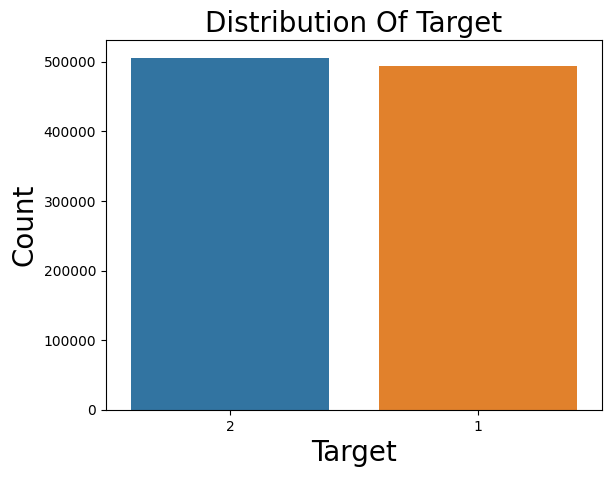

In [ ]:
sns.countplot(x=pd.DataFrame(train_labels)[0])
plt.title('Distribution Of Target',fontsize=20)
plt.xlabel('Target',fontsize=20)
plt.ylabel('Count',fontsize=20)

In [ ]:
pd.DataFrame(test_labels).value_counts()


2    25374
1    24626
Name: count, dtype: int64

Text(0, 0.5, 'Count')

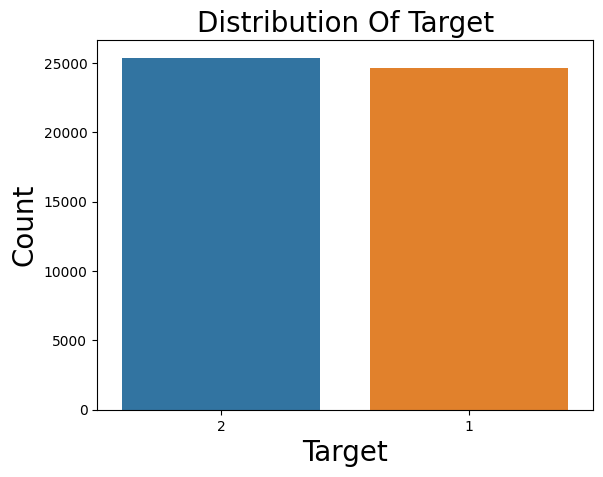

In [ ]:
sns.countplot(x=pd.DataFrame(test_labels)[0])
plt.title('Distribution Of Target',fontsize=20)
plt.xlabel('Target',fontsize=20)
plt.ylabel('Count',fontsize=20)

In [ ]:
train=pd.DataFrame(train)[0].apply(clean_text)
test=pd.DataFrame(test)[0].apply(clean_text)
test.head()

0     great cd my lovely pat has one of the great v...
1     one of the best game music soundtracks for a ...
2     batteries died within a year i bought this ch...
3     works fine but maha energy is better check ou...
4     great for the nonaudiophile reviewed quite a ...
Name: 0, dtype: object

In [ ]:
train.head()


0     stuning even for the nongamer this sound trac...
1     the best soundtrack ever to anything im readi...
2     amazing this soundtrack is my favorite music ...
3     excellent soundtrack i truly like this soundt...
4     remember pull your jaw off the floor after he...
Name: 0, dtype: object

In [ ]:
data = {
    'text': train,
    'textLabels':train_labels
}

# Create DataFrame
df_train = pd.DataFrame(data)
df_train.head()

,text,textLabels
0,stuning even for the nongamer this sound trac...,2
1,the best soundtrack ever to anything im readi...,2
2,amazing this soundtrack is my favorite music ...,2
3,excellent soundtrack i truly like this soundt...,2
4,remember pull your jaw off the floor after he...,2


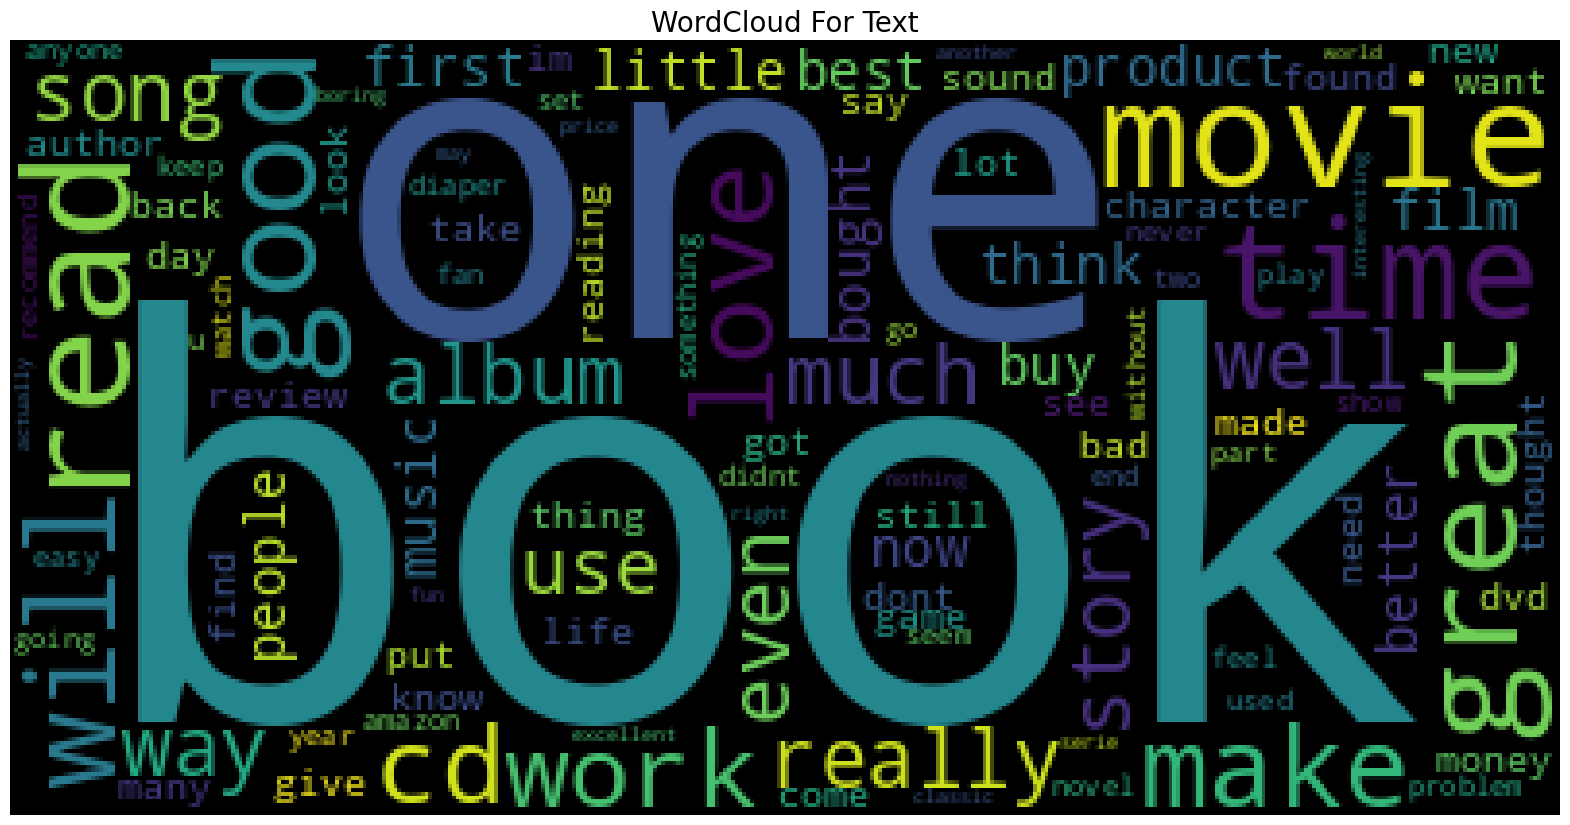

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(" ".join(train.iloc[:20000])))
plt.axis("off")
plt.title("WordCloud For Text",fontsize=20)
plt.show()

> This code creates a word cloud that shows the most frequent words in a set of texts, and this helps in understanding the most important topics and ideas discussed in these texts.

In [ ]:
voc_size=20000
max_length=100
tokenizer=Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(train)
word_index=tokenizer.word_index
with open('/kaggle/working/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

> This code sets up a rasterization tool to convert texts into a digital representation suitable for modeling, determines the size of the items and the maximum length of the sequences, and saves the tool after initialization in order to use it in the next steps.

In [ ]:
train=tokenizer.texts_to_sequences(train)
train=pad_sequences(train,maxlen=max_length)
test=tokenizer.texts_to_sequences(test)
test=pad_sequences(test,maxlen=max_length)

1. Convert text into digital sequences using the tokenizer tool.
1. Standardizing the lengths of sequences so that they are compatible with the machine learning model that will be trained on it.
1. This allows the model to deal with texts effectively during the training and testing process.

In [ ]:
train_lab=np.array([1 if i=='2' else 0 for i in train_labels])
test_lab=np.array([1 if i=='2' else 0 for i in test_labels])


> Converting text tags in the form of '2' or any other tags into binary numbers (1 or 0).
> This is important because the machine learning model being trained will often handle numbers better than text.
> The number 1 here indicates a positive result or the presence of a certain characteristic, and the number 0 indicates its absence.
> Converting labels in this way helps simplify the training process and improve model performance.

In [ ]:
train_lab[:15]


array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0])

In [ ]:
model=Sequential()
model.add(Embedding(input_dim=voc_size, output_dim=64, input_length=max_length))

model.add(LSTM(units=32,return_sequences=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(units=32))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           1280000   
                                                                 
 lstm (LSTM)                 (None, 100, 32)           12416     
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 32)           0         
 Dropout1D)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1300769 (4.96 MB)
Trainable params: 1300769 (4.96 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

> Embedding layer to convert digital representations of words into vector representations.
> Two layers of LSTM to process text sequences and learn relationships between words.
> Spatial dropout layer to reduce overfitting.
> Dense layer to output binary prediction based on text processing.

In [ ]:
checkpoint_cb=ModelCheckpoint('amazon_model.h5',save_best_only=True)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit(train,train_lab,epochs=2,validation_split=.2,
                 callbacks=[checkpoint_cb])

Epoch 1/2
25000/25000 [==============================] - 2413s 96ms/step - loss: 0.2178 - accuracy: 0.9136 - val_loss: 0.1865 - val_accuracy: 0.9274
Epoch 2/2
    1/25000 [..............................] - ETA: 35:30 - loss: 0.1101 - accuracy: 0.9375

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25000/25000 [==============================] - 2394s 96ms/step - loss: 0.1640 - accuracy: 0.9379 - val_loss: 0.1752 - val_accuracy: 0.9316


> Create a checkpoint to save the best version of the model during training.
> Prepare the model for training by specifying the loss function, optimization algorithm, and metrics.
> Start the training process on the data while tracking performance on the validation set and saving the best version of the model.

In [ ]:
loss,accuracy = model.evaluate(test, test_lab)
print("Loss:", loss)
print("Accuracy:", accuracy)

1563/1563 [==============================] - 44s 28ms/step - loss: 0.1790 - accuracy: 0.9312
Loss: 0.17898231744766235
Accuracy: 0.9311599731445312


In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import pickle

# Load the saved tokenizer
with open('/kaggle/working/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load the saved model
model = load_model('amazon_model.h5')

# Example new texts to classify
new_texts = ["he was so good", "I am not happy with this purchase."]

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(new_texts)

# Pad the sequences
max_length = 100  # This should be the same max_length used during training
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Make predictions
predictions = model.predict(padded_sequences)

# Convert the predictions to binary labels
binary_predictions = (predictions > 0.5).astype(int)

# Interpret the predictions
for text, pred in zip(new_texts, binary_predictions):
    sentiment = 'Positive' if pred == 1 else 'Negative'
    print(f'Text: "{text}" - Sentiment: {sentiment}')


1/1 [==============================] - 3s 3s/step
Text: "he was so good" - Sentiment: Positive
Text: "I am not happy with this purchase." - Sentiment: Negative


In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


In [ ]:
# Make predictions on the test data
predictions = model.predict(test)

# Convert the predictions to binary labels
binary_predictions = (predictions > 0.5).astype(int)


1563/1563 [==============================] - 46s 30ms/step


In [ ]:
test_labels = [int(label) for label in test_labels]
test_labels[0]

2

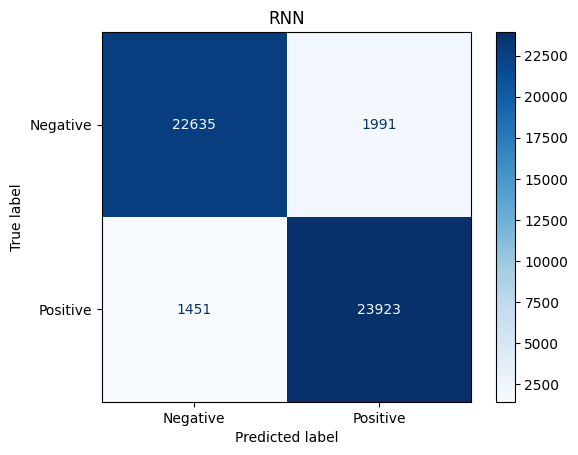

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(test_lab, binary_predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('RNN')
plt.show()

In [ ]:
report = classification_report(test_lab, binary_predictions)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     24626
           1       0.92      0.94      0.93     25374

    accuracy                           0.93     50000
   macro avg       0.93      0.93      0.93     50000
weighted avg       0.93      0.93      0.93     50000



In [ ]:
len(test_lab)

50000

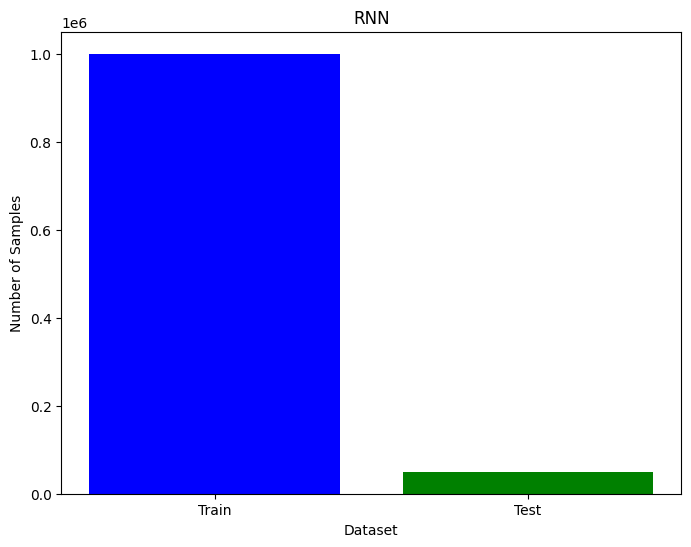

In [ ]:
# Data
labels = ['Train', 'Test']
counts = [len(train_lab), len(test_lab)]

# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['blue', 'green'])
plt.title('RNN')
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
pd.DataFrame(history.history)

In [ ]:
print('Number of samples in test:', test.shape[0])
print('Number of samples in test_lab:', test_lab.shape[0])

In [ ]:
prediction=model.predict(test)
y_pred=np.where(prediction>0.5,1,0)
df=pd.DataFrame()
df["Actual"],df['Pred']=test_lab,y_pred

In [ ]:
df

In [ ]:
CM = confusion_matrix(test_lab, y_pred)
sns.heatmap(CM,annot=True,center = True,fmt='g',cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(test_lab,y_pred)
print('Classification Report is : ', ClassificationReport)
